In [22]:
import pandas as pd
import utils_max_flow as utils
import pickle

In [23]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [24]:
# Toggle to run N-k or just print stored results
run_analysis = False

----
# Heuristics

### Node removal

In [ ]:
"""
Avrgd. results from 10 benchmarks 
"""
if run_analysis:
    random_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='random', remove='node', k_removals=60, n_benchmarks=5)
    random_node_removal_df.to_pickle('results/max_flow/iggielgn/hybrid/random_node_removal_df.pkl')
random_node_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/random_node_removal_df.pkl')

In [26]:
random_node_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/results_pre_6april/random_node_removal_df.pkl')

In [27]:
"""
32m 
"""
if run_analysis:
    FC_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='node')
    FC_node_removal_df.to_pickle('results/max_flow/iggielgn/hybrid/FC_node_removal_df.pkl')
FC_node_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/FC_node_removal_df.pkl')
utils.results_summary(FC_node_removal_df, 'capacity_robustness_max_flow')

Heuristic: entity criticality index

First entity removals:
----------------------------------------------
 it  removed_entity  diff  pct_change
  1       LKD_N_164  0.38       -38.0
  2    N_11_NS_LMGN  0.04        -6.5
  3     SEQ_12504_p  0.24       -41.3
  4 SEQ_369__L_LMGN  0.12       -34.9
  5     INET_N_1231  0.04       -17.9

Entity removals causing most damage, measured by: capacity_robustness_max_flow
----------------------------------------------
 it  removed_entity  diff  pct_change
  1       LKD_N_164  0.38       -38.0
  3     SEQ_12504_p  0.24       -41.3
  4 SEQ_369__L_LMGN  0.12       -34.9
  2    N_11_NS_LMGN  0.04        -6.5
  5     INET_N_1231  0.04       -17.9


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 0.16
Variation in damage per entity removal: 0.15
Area under the curve: 1.59
The metric reaches 0 at iteration 38.


In [28]:
"""
31m 
"""
if run_analysis:
    FCR_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='node')
    FCR_node_removal_df.to_pickle('results/max_flow/iggielgn/hybrid/FCR_node_removal_df.pkl')
FCR_node_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/FCR_node_removal_df.pkl')
utils.results_summary(FCR_node_removal_df, 'capacity_robustness_max_flow')

Heuristic: entity criticality index

First entity removals:
----------------------------------------------
 it  removed_entity  diff  pct_change
  1         NO_N_17  0.51       -51.0
  2    N_791_S_LMGN  0.07       -14.3
  3 SEQ_369__L_LMGN  0.12       -28.8
  4       SEQ_614_p -0.00         0.0
  5    N_193_M_LMGN  0.02        -6.7

Entity removals causing most damage, measured by: capacity_robustness_max_flow
----------------------------------------------
 it   removed_entity  diff  pct_change
  1          NO_N_17  0.51       -51.0
  3  SEQ_369__L_LMGN  0.12       -28.8
  2     N_791_S_LMGN  0.07       -14.3
 10        LKD_N_164  0.07       -35.1
  9 SEQ_1839__L_LMGN  0.05       -20.3


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 0.16
Variation in damage per entity removal: 0.2
Area under the curve: 2.44
The metric reaches 0 at iteration 41.


In [29]:
"""
28m 
"""
if run_analysis:
    WFCR_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='node')
    WFCR_node_removal_df.to_pickle('results/max_flow/iggielgn/hybrid/WFCR_node_removal_df.pkl')
WFCR_node_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/WFCR_node_removal_df.pkl')
utils.results_summary(WFCR_node_removal_df, 'capacity_robustness_max_flow')

Heuristic: entity criticality index

First entity removals:
----------------------------------------------
 it  removed_entity  diff  pct_change
  1         NO_N_17  0.51       -51.0
  2 SEQ_369__L_LMGN  0.12       -24.5
  3    N_791_S_LMGN  0.07       -18.9
  4    N_272_M_LMGN  0.04       -13.5
  5      SEQ_2285_p  0.07       -27.2

Entity removals causing most damage, measured by: capacity_robustness_max_flow
----------------------------------------------
 it  removed_entity  diff  pct_change
  1         NO_N_17  0.51       -51.0
  2 SEQ_369__L_LMGN  0.12       -24.5
  3    N_791_S_LMGN  0.07       -18.9
  5      SEQ_2285_p  0.07       -27.2
  4    N_272_M_LMGN  0.04       -13.5


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 0.16
Variation in damage per entity removal: 0.2
Area under the curve: 1.02
The metric reaches 0 at iteration 39.


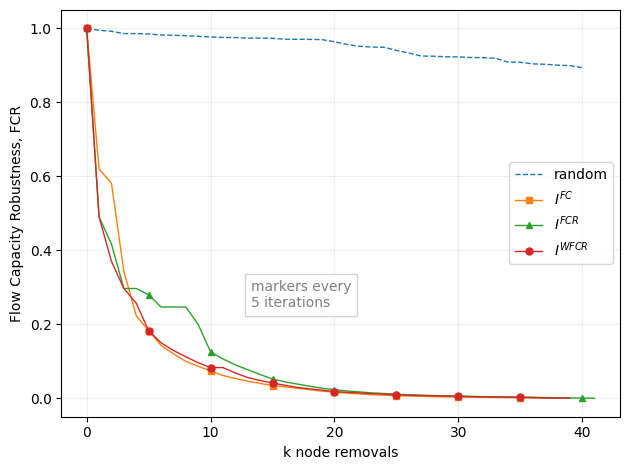

In [30]:
fig = utils.plot_heuristic_comparison_biplot([random_node_removal_df.head(41), FC_node_removal_df, FCR_node_removal_df, WFCR_node_removal_df])
# fig.savefig('saved_plots/iggielgn/hybrid/max_flow/node_removals.png')

### Edge removal

In [ ]:
"""
Avrgd. results from 8 benchmarks 
"""
if run_analysis:
    random_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='random', remove='edge', k_removals=65, n_benchmarks=2)
    random_edge_removal_df.to_pickle('results/max_flow/iggielgn/hybrid/random_edge_removal_df.pkl')
random_edge_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/random_edge_removal_df.pkl')

In [32]:
random_edge_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/results_pre_6april/random_edge_removal_df.pkl')

In [33]:
""" r1 = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df.pkl')
r2 = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df_more.pkl')
fig = utils.plot_heuristic_comparison_biplot([r1, r2])
 """

" r1 = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df.pkl')\nr2 = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df_more.pkl')\nfig = utils.plot_heuristic_comparison_biplot([r1, r2])\n "

In [34]:
""" avg = utils.average_dfs(r1, r2)
fig = utils.plot_heuristic_comparison_biplot([r1, r2, avg]) """

' avg = utils.average_dfs(r1, r2)\nfig = utils.plot_heuristic_comparison_biplot([r1, r2, avg]) '

In [35]:
""" 
avg.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df.pkl') """

" \navg.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df.pkl') "

In [36]:
if run_analysis:
    FC_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='edge')
    FC_edge_removal_df.to_pickle('results/max_flow/iggielgn/hybrid/FC_edge_removal_df.pkl')
FC_edge_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/FC_edge_removal_df.pkl')
utils.results_summary(FC_edge_removal_df, 'capacity_robustness_max_flow')

Heuristic: entity criticality index

First entity removals:
----------------------------------------------
 it                     removed_entity  diff  pct_change
  1             {LKD_N_165, LKD_N_164}  0.38       -38.0
  2            {NO_N_18, N_11_NS_LMGN}  0.04        -6.5
  3         {N_3_NS_LMGN, SEQ_12504_p}  0.24       -41.3
  4 {SEQ_369__L_LMGN, SEQ_373__L_LMGN}  0.12       -34.9
  5    {SEQ_5839__M_LMGN, INET_N_1231}  0.04       -17.9

Entity removals causing most damage, measured by: capacity_robustness_max_flow
----------------------------------------------
 it                     removed_entity  diff  pct_change
  1             {LKD_N_165, LKD_N_164}  0.38       -38.0
  3         {N_3_NS_LMGN, SEQ_12504_p}  0.24       -41.3
  4 {SEQ_369__L_LMGN, SEQ_373__L_LMGN}  0.12       -34.9
  2            {NO_N_18, N_11_NS_LMGN}  0.04        -6.5
  5    {SEQ_5839__M_LMGN, INET_N_1231}  0.04       -17.9


Summary statistics (first 150 removals)
----------------------------------------

In [37]:
if run_analysis:
    FCR_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='edge')
    FCR_edge_removal_df.to_pickle('results/max_flow/iggielgn/hybrid/FCR_edge_removal_df.pkl')
FCR_edge_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/FCR_edge_removal_df.pkl')
utils.results_summary(FCR_edge_removal_df, 'capacity_robustness_max_flow') 

Heuristic: entity criticality index

First entity removals:
----------------------------------------------
 it                     removed_entity  diff  pct_change
  1              {SEQ_2285_p, NO_N_17}  0.30       -30.0
  2   {SEQ_8387__L_LMGN, N_791_S_LMGN}  0.16       -23.0
  3      {SEQ_8163__M_LMGN, SEQ_444_p}  0.05        -9.3
  4 {SEQ_369__L_LMGN, SEQ_373__L_LMGN}  0.12       -24.6
  5            {SEQ_614_p, INET_N_329} -0.00         0.0

Entity removals causing most damage, measured by: capacity_robustness_max_flow
----------------------------------------------
 it                     removed_entity  diff  pct_change
  1              {SEQ_2285_p, NO_N_17}  0.30       -30.0
  2   {SEQ_8387__L_LMGN, N_791_S_LMGN}  0.16       -23.0
  4 {SEQ_369__L_LMGN, SEQ_373__L_LMGN}  0.12       -24.6
 12             {LKD_N_165, LKD_N_164}  0.07       -29.9
  3      {SEQ_8163__M_LMGN, SEQ_444_p}  0.05        -9.3


Summary statistics (first 150 removals)
----------------------------------------

In [38]:
if run_analysis:
    WFCR_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='edge')
    WFCR_edge_removal_df.to_pickle('results/max_flow/iggielgn/hybrid/WFCR_edge_removal_df.pkl')
WFCR_edge_removal_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/WFCR_edge_removal_df.pkl')
utils.results_summary(WFCR_edge_removal_df, 'capacity_robustness_max_flow') 

Heuristic: entity criticality index

First entity removals:
----------------------------------------------
 it                     removed_entity  diff  pct_change
  1              {SEQ_2285_p, NO_N_17}  0.30       -30.0
  2   {SEQ_8387__L_LMGN, N_791_S_LMGN}  0.16       -23.0
  3 {SEQ_369__L_LMGN, SEQ_373__L_LMGN}  0.12       -22.3
  4      {SEQ_8163__M_LMGN, SEQ_444_p}  0.05       -11.9
  5            {N_47_NS_LMGN, NO_N_17}  0.04       -10.9

Entity removals causing most damage, measured by: capacity_robustness_max_flow
----------------------------------------------
 it                     removed_entity  diff  pct_change
  1              {SEQ_2285_p, NO_N_17}  0.30       -30.0
  2   {SEQ_8387__L_LMGN, N_791_S_LMGN}  0.16       -23.0
  3 {SEQ_369__L_LMGN, SEQ_373__L_LMGN}  0.12       -22.3
  8            {SEQ_2285_p, LKD_N_164}  0.07       -24.7
  4      {SEQ_8163__M_LMGN, SEQ_444_p}  0.05       -11.9


Summary statistics (first 150 removals)
----------------------------------------

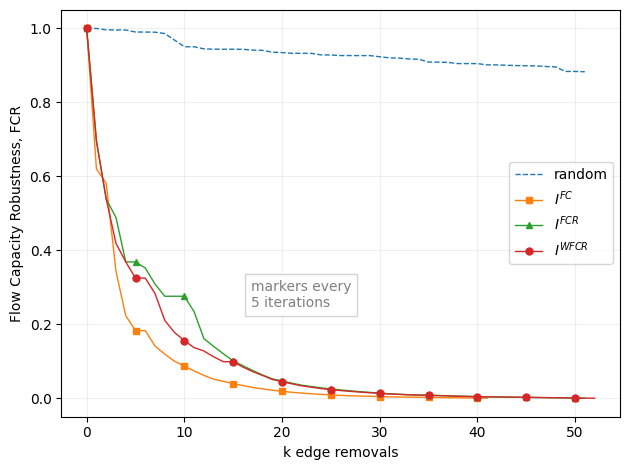

In [39]:
fig = utils.plot_heuristic_comparison_biplot([random_edge_removal_df.head(52), FC_edge_removal_df, FCR_edge_removal_df, WFCR_edge_removal_df])
# fig.savefig('saved_plots/iggielgn/hybrid/max_flow/edge_removals.png')